<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EB%AF%B8%EC%85%983_2%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자전거 대여 시스템 데이터 분석

1. 자전거 대여 패턴을 분석
2. 자전거 배치 및 운영 전략 최적화
3. 대여 수요를 정확하게 예측
4. 대여 시스템의 효율 성 높이기
5. 사용자의 만족도를 증가
6. RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추기


7:3 8:2 학습

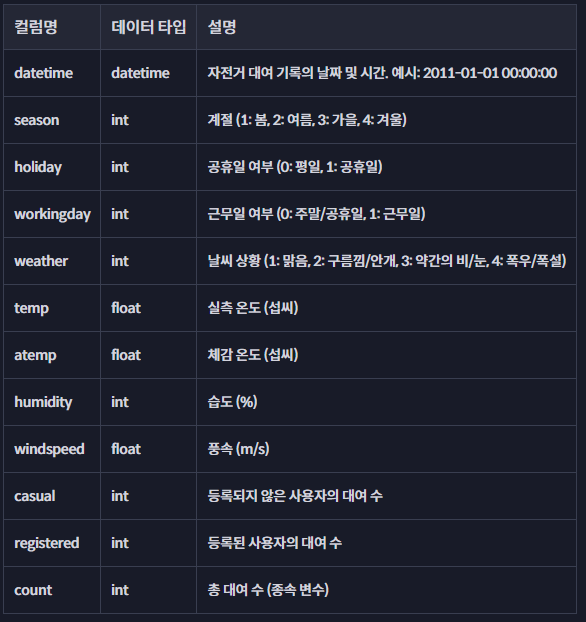

train.csv 파일에는 count 컬럼이 포함되어 있으며, 예측 대상인 종속 변수입니다.
test.csv 파일에는 casual, registered, count 컬럼이 포함되어 있지 않습니다.
casual과 registered는 자전거 대여 수요를 예측하는데 참고하실만한 자료이며, count는 두 컬럼간의 합입니다.
예시 분석 질문
어떤 방향으로 분석해야 할지 고민되신다면, 예시 질문들을 바탕으로 다양한 관점에서 데이터를 탐색하고 분석해보세요.

특정 시간대의 자전거 대여 패턴은 무엇인가요?
날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가요?
계절별 자전거 대여 패턴의 차이는 무엇인가요?
주말과 평일의 자전거 대여 수요 차이는 무엇인가요?
자전거 대여 수요를 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가요?
자전거 대여 수요 예측 모델을 구축하고, 이를 기반으로 한 운영 전략을 제안해보세요.
제출 내용
분석과정 및 분석 결과가 포함된 Colab Notebook
가설, 분석의 전개, 인사이트 등이 포함된 보고서

In [141]:
# 데이터 불러오기

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
# train 데이터 및 test 데이터 불러오

import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/ai05/train1.csv')
test = pd.read_csv('/content/drive/MyDrive/ai05/test1.csv')

In [143]:
# 데이터 미리보기

from IPython.display import display

display(train.head())
display(test.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [144]:
# 날짜 분리 (시간적 패턴을 위해)

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(train['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

In [145]:
# 전처리
# casual과 registered 의 합이 count니 두 컬럼을 삭제하고  datetime도 삭제해줍니다

train = train.drop(['casual', 'registered', 'datetime'], axis=1)
test = test.drop(['datetime'], axis=1)

In [146]:
print(train.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour',
       'weekday'],
      dtype='object')


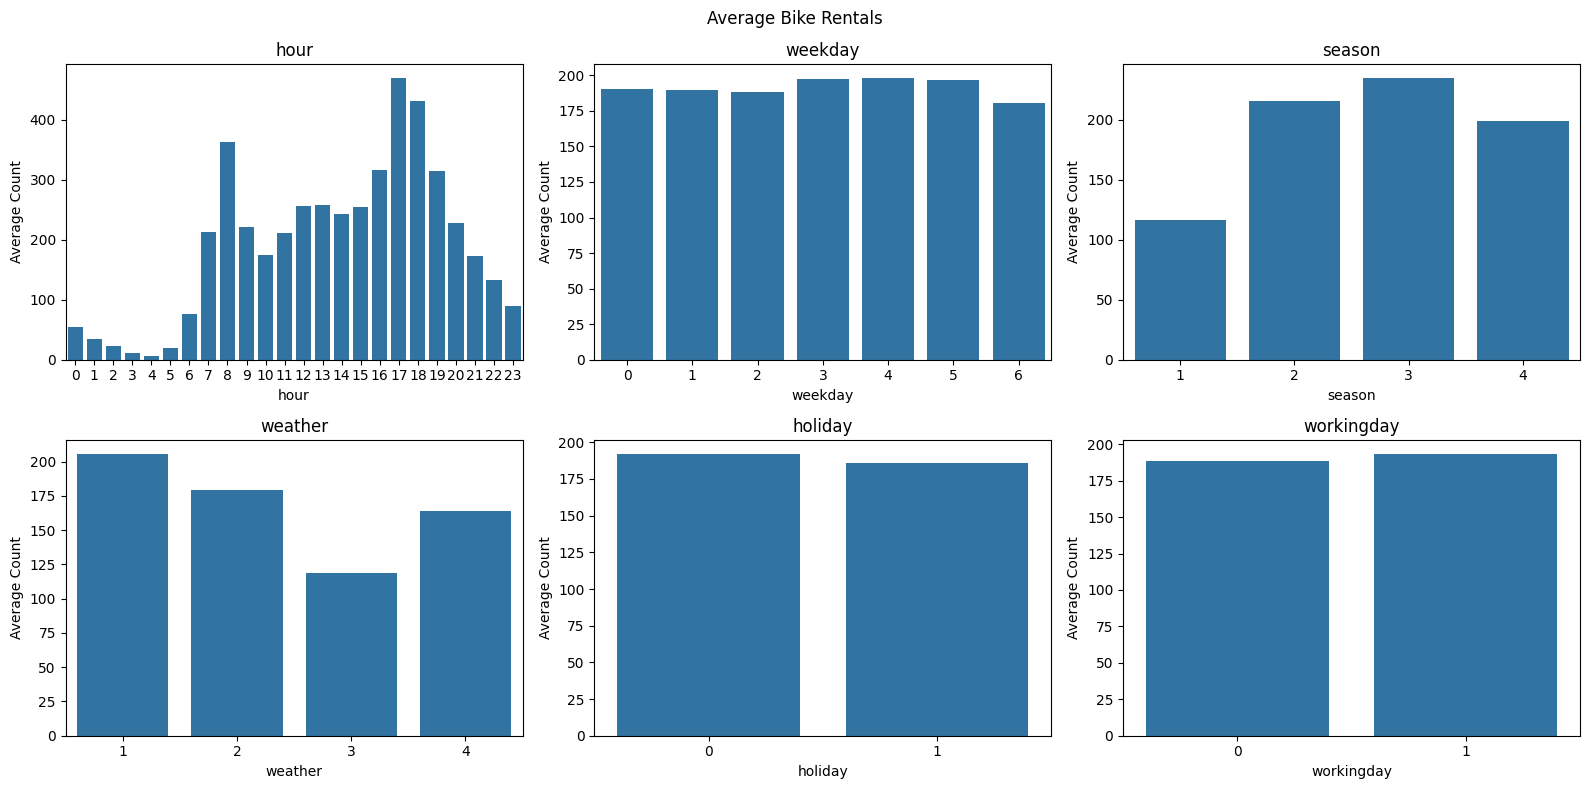

In [147]:
# 시간대별 평균 자전거 대여량 시각화

import matplotlib.pyplot as plt
import seaborn as sns

features = ['hour', 'weekday', 'season', 'weather', 'holiday', 'workingday']

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
fig.suptitle('Average Bike Rentals')

for i , feature in enumerate(features):
  row = i // 3                            # 1,2,3 = 0 4,5,6 = 1
  col = i % 3                             # 0,3 = 0 1,4 = 1 , 2, 5 = 2

  avg_counts = train.groupby(feature)['count'].mean()         # 그룹에 속한 count 값의 평균을 계산

  sns.barplot(x=avg_counts.index, y=avg_counts.values, ax=axes[row,col])
  axes[row,col].set_xlabel(feature)
  axes[row,col].set_ylabel('Average Count')
  axes[row,col].set_title(f'{feature}')

plt.tight_layout()
plt.show()


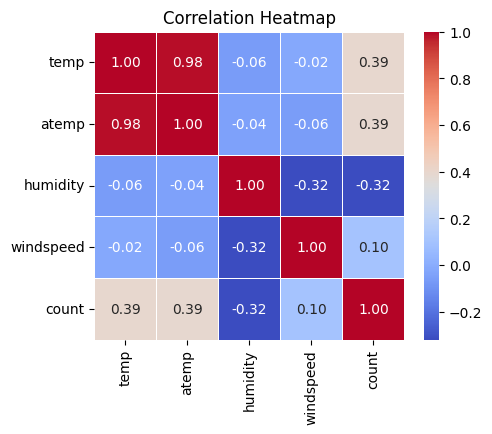

In [148]:
# 히트맵으로 그려보기

import matplotlib.pyplot as plt
import seaborn as sns

features = ['temp', 'atemp', 'humidity', 'windspeed','count']

corr_matrix = train[features].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [149]:
# 중복된 행의 수

print(f"중복된 행 수: {train.duplicated().sum()}")

중복된 행 수: 0


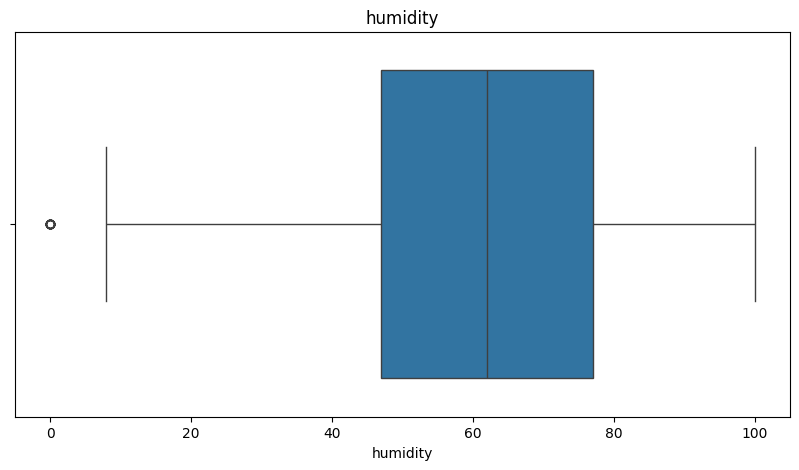

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x=train['humidity'])
plt.title('humidity')
plt.show()

In [151]:
# 습도가 0이거나 풍속이 0 인 데이터수 확인

print(f"습도가 0인 데이터 수 : {len(train[train['humidity'] == 0])}")
print(f"풍속이 0인 데이터 수 : {len(train[train['windspeed'] == 0])}")

습도가 0인 데이터 수 : 22
풍속이 0인 데이터 수 : 1313


In [152]:
# 습도를 중앙값으로 대체하기

humidity_zero = train[train['humidity'] == 0].index

humidity_mid = train['humidity'].median()

train.loc[humidity_zero, 'humidity'] = humidity_mid

print(f"습도가 0인 데이터 수 : {len(train[train['humidity'] == 0])}")

습도가 0인 데이터 수 : 0


In [153]:
# 풍속을 중앙값으로 대체하기

windspeed_zero =  train[train['windspeed'] == 0].index

windspeed_mid = train['windspeed'].median()

train.loc[windspeed_zero, 'windspeed'] = windspeed_mid

print(f"풍속이 0인 데이터 수 : {len(train[train['windspeed'] == 0])}")

풍속이 0인 데이터 수 : 0


In [154]:
# 폭우/폭설시 자전거 대여 수
# weather가 4인 데이터가 현저히 적어서 학습의 효과가 떨어질것으로 판단 3(약간비),4(폭우)를 같은 데이터로 취급

print(f"train 데이터의 weather 4인 경우: {len(train[train['weather']==4])}건")
print(f"test 데이터의 weather 4인 경우: {len(test[test['weather'] == 4])}건")



train 데이터의 weather 4인 경우: 1건
test 데이터의 weather 4인 경우: 2건


In [155]:
# weather 4를 3으로 변경

train['weather'] = train['weather'].replace(4,3)
test['weather'] = test['weather'].replace(4,3)

print(f"train 데이터의 weather 4인 경우: {len(train[train['weather']==4])}건")
print(f"test 데이터의 weather 4인 경우: {len(test[test['weather'] == 4])}건")

train 데이터의 weather 4인 경우: 0건
test 데이터의 weather 4인 경우: 0건


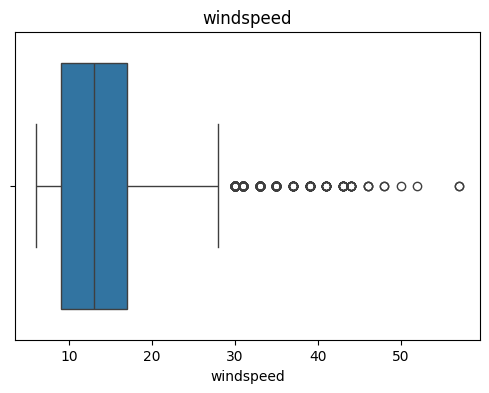

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(x=train['windspeed'])
plt.title('windspeed')
plt.show()

In [157]:
# 풍속을 값을 학습할때 30정도를 최대값으로 설정

train['windspeed'] = train['windspeed'].apply(lambda x: 30 if x > 30 else x)  # 람다식 lambda (True일때) if (조건문) else (False일때)
test['windspeed'] = test['windspeed'].apply(lambda x: 30 if x > 30 else x)

print(f"train['windspeed'] : {train['windspeed'].max()}")
print(f"test['windspeed'] : {test['windspeed'].max()} ")

train['windspeed'] : 30.0
test['windspeed'] : 30.0 


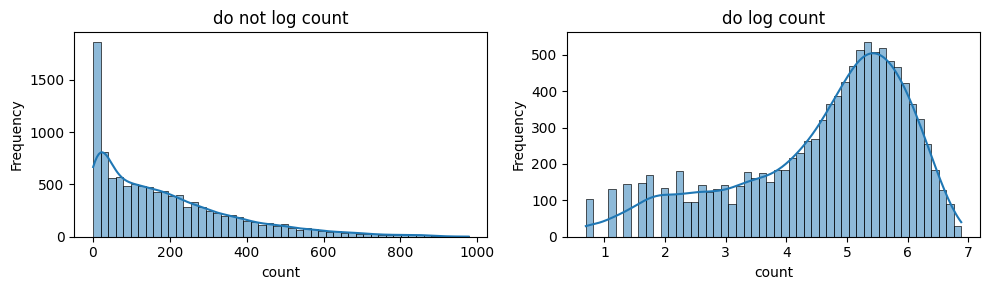

In [158]:
# 타켓 변수를 log로 변환하기
# 치우친 그래프의 타겟변수를 처리할때 가장 좋은것 1. 로그화(너무 큰값이있을때) 2. 박스콕스(분포도가 뒤죽박죽) 3. 제곱근 변환 (약한 로그화)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2) = plt.subplots(nrows=1 , ncols=2, figsize=(10,3))

sns.histplot(train['count'], bins=50, kde=True, ax=ax1)
ax1.set_title('do not log count')
ax1.set_xlabel('count')
ax1.set_ylabel('Frequency')

train['count'] = np.log1p(train['count'])

sns.histplot(train['count'], bins=50, kde=True, ax=ax2)
ax2.set_title('do log count')
ax2.set_xlabel('count')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

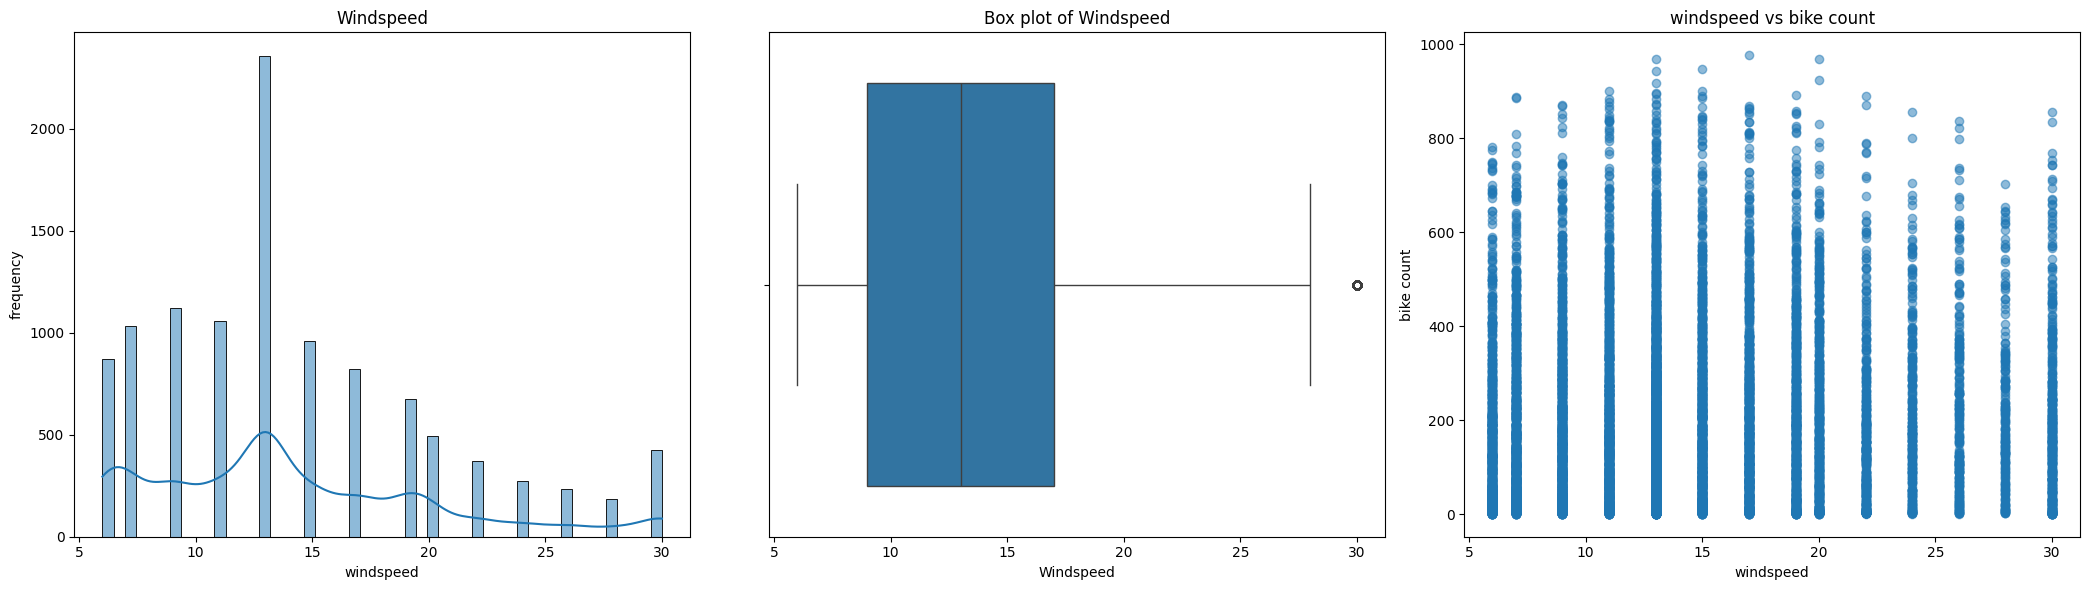

In [159]:
# 풍속 시각화하기

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21,6))

sns.histplot(train['windspeed'], bins=50, kde=True, ax=ax1) #kde를 통해 밀도를 확인
ax1.set_title('Windspeed')
ax1.set_xlabel('windspeed')
ax1.set_ylabel('frequency')

sns.boxplot(x=train['windspeed'], ax=ax2)
ax2.set_title('Box plot of Windspeed')
ax2.set_xlabel('Windspeed')

ax3.scatter(train['windspeed'], np.expm1(train['count']), alpha=0.5)
ax3.set_title('windspeed vs bike count')
ax3.set_xlabel('windspeed')
ax3.set_ylabel('bike count')

plt.tight_layout()
plt.show()

In [160]:
# 독립 변수 종속변수 분리

y_train = train['count']
X_train = train.drop('count', axis=1)

In [161]:
# 데이터셋은 종속변수 없으므로 그대로 진행

X_test = test

In [162]:
# 범주형 변수 원-핫 인코딩
# 봄이 1이고 겨울이 4면 봄이 겨울보다 4배가 크다라는 말은 아니니
# 원핫인코딩으로 isspring iswinter처럼 새로운 변수를 만들고 0,1 TF로 설정해놓는 방법

categorical_features = ['year', 'month', 'day', 'hour', 'weekday', 'season', 'weather', 'holiday', 'workingday']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, prefix=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, prefix=categorical_features)

In [163]:
# train test 데이터셋 컬럼일치
# 컬럼 순서를 맞추는 작업 1,2,3 3,1,2 이런 두테이블을 1,2,3으로 통일시키는 작업

common_cols = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))
X_train_final = X_train_encoded[common_cols]
X_test_final = X_test_encoded[common_cols]

In [164]:
# 수치형 변수 스케일링
# 모델을 학습할때 각 변수가 공정하게 학습하도록 돕는 매우 중요한 처리
# 각 변수의 값이 0 표준편차가 1이 되도록 변환합니다
# 이뉴는 온도는 0 ~40 사이고 습도는 0~100이니까 습도에 더큰 영향을 끼치는것을 방지하기 위해서 수치형 변수 스케일링을 진행합니다

from sklearn.preprocessing import StandardScaler

numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
scaler = StandardScaler()
X_train_final[numerical_features] = scaler.fit_transform(X_train_final[numerical_features])
X_test_final[numerical_features] = scaler.fit_transform(X_test_final[numerical_features])

In [165]:
# 모델 학습

from sklearn.linear_model import LinearRegression

model = LinearRegression()          # 공부하는 방법을 model에 넣는다
model.fit(X_train_final, y_train)   # 첫번째 파라미터에는 문제집 두번재는 정답지

LinearRegression()

In [166]:
# RMSLE 계산 함수 생성 (비율로 모델을 평)
# 모델 예측 결과가 얼마나 정확한지 확인

from sklearn.metrics import mean_squared_error

def rmsle(y_true, y_pred):
  y_pred[y_pred < 0] = 0                                                  # 음수가 있다면 0 으로 변환
  return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))  # 로그변환

In [167]:
# 예측 및 RMSLE 점수 출력
# 왜한번더 X train으로 하냐 자신이 공부한 내용을 얼마나 잘이해했는지 확인하기위해

train_predictions = model.predict(X_train_final)

In [168]:
# 예측값 제한 오버플로 방지를 위해 예측값을 18 이하로 제한

train_predictions[train_predictions > 18] = 18      # 로그한값이 18이상이 되는 값이면 6500만이넘는 숫자로 변환대기에 방지하기 위한 코

rmsle_score = rmsle(np.expm1(y_train), np.expm1(train_predictions))
print(f"RMSLE: {rmsle_score:.4f}")

RMSLE: 0.5763


In [170]:
# 최종 예측 결과 파일 생성
predictions_test = model.predict(X_test_final)
predictions_test[predictions_test < 0] = 0 # 음수값 0으로 보정
predictions_test = np.expm1(predictions_test) # 원래 스케일로 복원

In [171]:
# submission.csv 파일 생성
submission = pd.DataFrame({
    'datetime': pd.read_csv('/content/drive/MyDrive/ai05/test1.csv')['datetime'],
    'count': predictions_test
})

submission.to_csv('submission.csv', index=False)
print("submission.csv 파일이 성공적으로 생성되었습니다.")

submission.csv 파일이 성공적으로 생성되었습니다.


In [172]:
# 파일 다운로드

from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 풍속을 처리할떄 숫자로인해서 RMSLE스코어 값이 많이달라진다
# 0.30 xgboost

가설 설정
시간, 날씨, 계절이 자전거 대여 수요에 영향을 미치나?

시간으로 보았을대 출퇴근 시간인 오전 8시나 오후 5~6시에 대여량이 가장 많은것을 확인했습니다
이로 인해서 직장인들의 수요가 크다는걸 알 수 있습니다

날씨로 보았을때 맑은날 'weather'가 1일때 대야량이 증가하고 3에 가까울수록 줄어들었고 4에는 대여량이 거의 없다는걸 알 수 있습니다



선형 회귀모델로 0.5763이라는 훌